<H1>Monte Carlo for Options<H1>

In [12]:
import math 
import scipy.stats as stats
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf

<h2> What is Monte Carlo Simulation
<p><h4> Monte Carlo simulations is a way of solving probabilistic problems by numerically simulating many possible scenarios so that you may calculate statistical properties of the outcomes, such as expectations, variances of probabilities of certain outcomes. 
In the case of Financial Derivatives, this gives us a handy tool for which to price complex derivatives for which and analytical formulae is not possible. 
First used by Boyle in 1977, Monte Carlo simulation provides an easy way to deal with multiple random factors and the incorporation of more realistic asset price processes such as jumps in asset prices. <h4><p>

<h2> Monte Carlo as a tool <h2>
We can solve two types of financial problems:
<p>
<h4>
1.Portfolio statistics (Brownian Motion is representative of Real probabilities under P-measure)    
– Expected returns    
– Risk metrics (VaR, CVaR, …)    
– Downside risks (Drawdown metrics,…)    
– other probabilities of interest   
<h4>
 <p>

<h4> 2. Pricing derivatives with risk-neutral pricing (Brownian Motion is representative of risk-neutral probabilities under ℚ-measure) <h4>

In [27]:
def get_data(stocks, start, end ):
    stockData = yf.download(stocks, start= startDate, end= endDate)
    stockData = stockData["Close"]
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

# this is the  stocks that are searched through Y Finance stock data 
# stocks = ["BABA","AMZN","BIDU","META","JPM","GS","AAPL","KO","GM","XOM","OXY"]
stocks = ["LLY","BABA","NTLA","HHC"]
# endDate is the current data as is
endDate = datetime.datetime.now()
#startDate = Current Date - dt Delta Time 300 days #! days is good number to mess with 
startDate = endDate - datetime.timedelta(days= 300)
# this takes the meanReturns and takes the covariance Matrix which stores data
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
print(meanReturns)

[*********************100%***********************]  4 of 4 completed
BABA    0.000328
HHC     0.001238
LLY     0.001369
NTLA    0.000549
dtype: float64


In [28]:
# this creates the shape of the matrix, this is important because it assigns random weightings and has no bias

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

print(weights)


[0.2493187  0.30607939 0.20302157 0.24158034]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


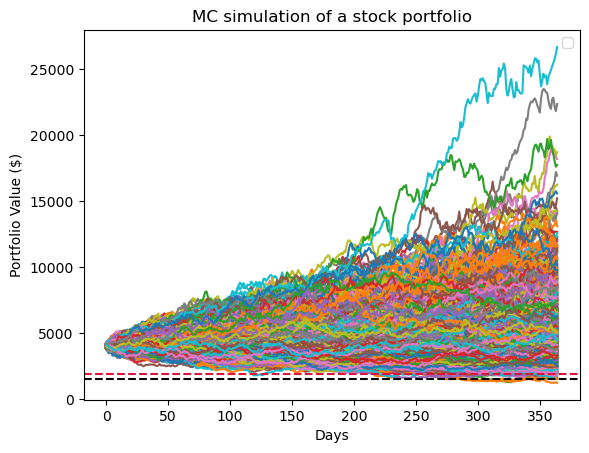

 Value at Risk :VaR $ 1531.63
 Conditional value-at-risk CVaR $ 1899.2


In [30]:
mc_sims = 1000 #! great numbers to test out number of simulations the it will run 
T = 365 # timeframe in days 

meanM = np.full(shape= (T, len(weights)), fill_value = meanReturns)
meanM = meanM.T 

portfolio_sims = np.full(shape = (T, mc_sims), fill_value= 0.0)

initialPortfolio = 4000 # this is the number assigned to the portfolio initally

for m in range(0, mc_sims):  #? T = Timeframe in days 
    #MC Loops       #?      (T * Number of stocks we have) 
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix) #! finds lower triangle for Cholesky Decompesition
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio # This accounts for the cumlative effect of daily Return

def mcVAR(returns, alpha = 5 ):
    "Input : pandas series of returns"
    "Output: CVar or Expected Shortfall to a given confidence level alpha"
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError ("Expected a pandas data series.")
    
    
def mcCVAR(returns, alpha = 5 ):
    "Input : pandas series of returns"
    "Output: McCVar or Expected Shortfall to a given confidence level alpha"
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVAR(returns, alpha = alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError ("Expected a pandas data series.")
    
    
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVAR(portResults, alpha = 5)
CVaR = initialPortfolio -  mcCVAR(portResults, alpha = 5)

plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("MC simulation of a stock portfolio")
plt.axhline(y=CVaR, color='Crimson', linestyle='--')
plt.axhline(y=VaR, color='Black', linestyle='--')
plt.legend()
plt.show()


print(" Value at Risk :VaR $ {}".format(round(VaR,2)))
print(" Conditional value-at-risk CVaR $ {}".format(round(CVaR,2)))


<h3>Real World Example Calculator for Monte carlo, This can be used while trading to show fair value<h3>

In [23]:
S = 39.06  # stock price
K = 40.0   #strike price 
vol = 59.47 # volatility % 
r = 0.048  # risk - free rate  %
N =4  # Number of steps 
M = 10000  # number of simulations %

market_value = 1.00
# premlimary negative sign put infront of function because at t
T = ((datetime.date.today() - datetime.date(2022,3,17)).days+1)/365
datetime.date.today()
if T < 0:
    print(f"Error Value  T: {T}, (T cannot be less than 0, T - Value Cannot be negative) " )
else: 
    print(T)
    
p = datetime.date.today()
    

1.0767123287671232


In [17]:
datetime.date.today()

datetime.date(2023, 4, 13)

<H3>Fast Solution - Vectorized<H3>

In [18]:
# precompute constants 
dt =  T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size = (N,M))
delta_lnSt = nudt + volsdt * Z
lnSt = lnS + np.cumsum(delta_lnSt, axis = 0)
lnSt = np.concatenate((np.full(shape = (1,M), fill_value = lnS), lnSt))


# Compute Expectation and SE 
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt(np.sum( (CT[-1]- C0)**2)/(M-1))
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $113.77 with SE +/- 52.14


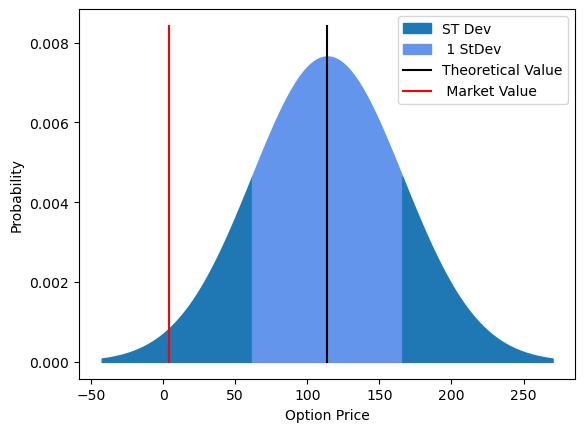

In [19]:

x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)


plt.fill_between(x1,s1,color = "tab:blue",label = "ST Dev")
plt.fill_between(x2,s2,color = "cornflowerblue",label = ' 1 StDev')
plt.fill_between(x3,s3,color = "tab:blue")

plt.plot([C0,C0],[0,max(s2)*1.1], "k",
         label = "Theoretical Value")
plt.plot([market_value,market_value],[0,max(s2)*1.1], "r", label = " Market Value")

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()